# MRIReco.jl
#### Julia package for MRI reconstruction

by Tobias Knopp and Mirco Grosser

## Overview

* Introduction to Julia
* MRIReco: Architecture
* MRIReco: Examples


# Julia

* High level programming language with Matlab like syntax
* Provides a powerful REPL for interactive use
* Strongly influenced by C++ and Python
* Generates efficient machine code:
  no need to write perfromance critical things in C/C++

### In a nutshell: 

### Julia = (C++ $\cup$ Python $\cup$ Matlab) $\cap$ OnlyTheNiceThings

# Julia Tooling

Commonly Julia is developed in

* Packages: Several source files / modules grouped together
* Scripts: Usually load packages an perform a dedicated operation

Both can be interactively executed on the REPL. 

Within this tutorial, we will, however use a Jupyter notebook instead (not our usual workflow)

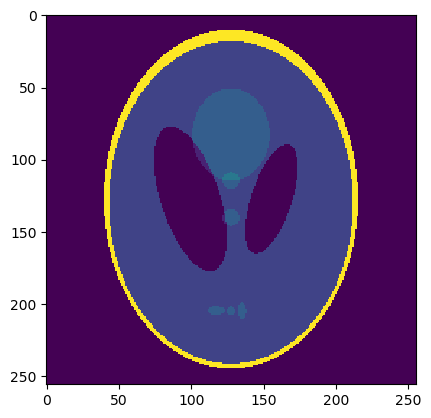

PyObject <matplotlib.image.AxesImage object at 0x147b7f320>

In [1]:
using Images
using PyPlot

p = shepp_logan(256)

imshow(p)

Lets do some image processing

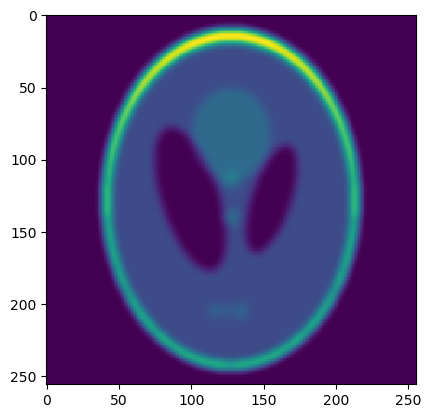

PyObject <matplotlib.image.AxesImage object at 0x147249c88>

In [2]:
pfilt = imfilter(p,Kernel.gaussian(3))

imshow(pfilt)

Lets switch into frequency space

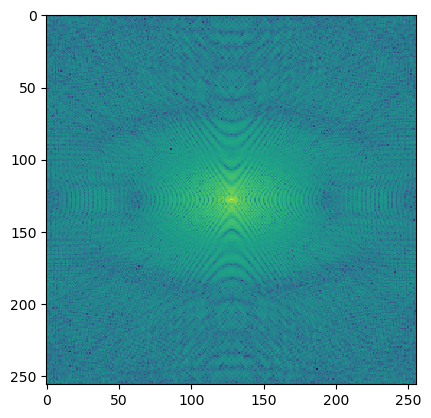

PyObject <matplotlib.image.AxesImage object at 0x1226febe0>

In [3]:
using FFTW

pFT = fftshift( fft(p) )
imshow(log.(abs.(pFT)))

Or lets look at the wavelet transform

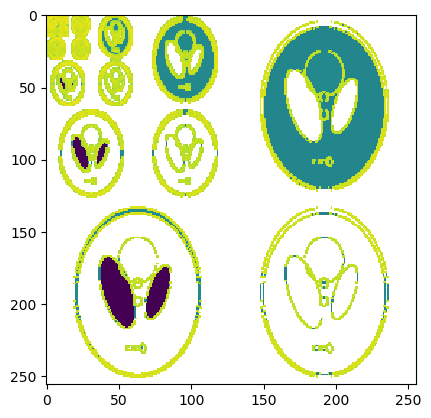

PyObject <matplotlib.image.AxesImage object at 0x13141cbe0>

In [5]:
using Wavelets

pW = dwt(p, wavelet(WT.db2))
imshow( log.(abs.(pW)) )

# Dot syntax

What is that for a strange dot before the log and abs?

In [4]:
methods(abs)

# 23 methods for generic function "abs":
[1] abs(x::Bool) in Base at bool.jl:91
[2] abs(x::Float16) in Base at float.jl:520
[3] abs(x::Float32) in Base at float.jl:521
[4] abs(x::Float64) in Base at float.jl:522
[5] abs(::Missing) in Base at missing.jl:83
[6] abs(a::Pkg.Resolve.VersionWeights.VersionWeight) in Pkg.Resolve.VersionWeights at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Pkg/src/resolve/VersionWeights.jl:40
[7] abs(a::Pkg.Resolve.MaxSum.FieldValues.FieldValue) in Pkg.Resolve.MaxSum.FieldValues at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Pkg/src/resolve/FieldValues.jl:67
[8] abs(a::PyCall.PyObject) in PyCall at /Users/knopp/.julia/packages/PyCall/ttONZ/src/pyoperators.jl:41
[9] abs(x::Unsigned) in Base at int.jl:135
[10] abs(x::Signed) in Base at int.jl:136
[11] abs(x::Rational) in Base at rational.jl:231
[12] abs(x::Fixed{T,f}) where {T, f} in FixedPointNumbers at /Users/knopp/.julia/packages/FixedPointNumbers/3QAEg/src/fixed.jl:34
[13] abs(x::Normed) in FixedPointNumbers at /Users/knopp/.julia/packages/FixedPointNumbers/3QAEg/src/normed.jl:86
[14] abs(x::Real) in Base at number.jl:144
[15] abs(z::Complex) in Base at complex.jl:260
[16] abs(a::T) where T<:Dates.Period in Dates at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Dates/src/periods.jl:97
[17] abs(c::AbstractRGB{T}) where T<:Normed in ColorVectorSpace at /Users/knopp/.julia/packages/ColorVectorSpace/HeIVH/src/ColorVectorSpace.jl:164
[18] abs(c::AbstractRGB) in ColorVectorSpace at /Users/knopp/.julia/packages/ColorVectorSpace/HeIVH/src/ColorVectorSpace.jl:163
[19] abs(c::TransparentColor{C,T,4} where T where C<:AbstractRGB) in ColorVectorSpace at /Users/knopp/.julia/packages/ColorVectorSpace/HeIVH/src/ColorVectorSpace.jl:165
[20] abs(c::TransparentColor{T,T1,4} where T1) where T<:Normed in ColorVectorSpace at /Users/knopp/.julia/packages/ColorVectorSpace/HeIVH/src/ColorVectorSpace.jl:166
[21] abs(c::Color{T,1} where T) in ColorVectorSpace at /Users/knopp/.julia/packages/ColorVectorSpace/HeIVH/src/ColorVectorSpace.jl:210
[22] abs(c::TransparentColor{C,T,2} where T<:Normed where C<:(Color{T,1} where T)) in ColorVectorSpace at /Users/knopp/.julia/packages/ColorVectorSpace/HeIVH/src/ColorVectorSpace.jl:253
[23] abs(c::TransparentColor{C,T,2} where T where C<:(Color{T,1} where T)) in ColorVectorSpace at /Users/knopp/.julia/packages/ColorVectorSpace/HeIVH/src/ColorVectorSpace.jl:252

# Dot syntax

No vectorized version? It seems that the . operator can be applied to any scalar function:

In [5]:
myfunc(x::Number) = 5*x

a = ones(3)
myfunc(a)

MethodError: MethodError: no method matching myfunc(::Array{Float64,1})
Closest candidates are:
  myfunc(!Matched::Number) at In[5]:1

In [6]:
myfunc.(a)

3-element Array{Float64,1}:
 5.0
 5.0
 5.0

# MRIReco.jl

* Julia package intending to provide a powerfull MRI reconstruction toolbox
* In development (not as stable / feature complete as Gadgetron / BART)
* Focus on reconstruction researchers providing a hackable package
* Modular concept using existing goodies from Julialand

# MRIReco.jl

The following packages are used / outsourced so that MRIReco.jl can concentrate on glueing the pieces together

* FFTW.jl
* NFFT.jl
* Wavelets.jl
* LinearOperators.jl
* NIfTI.jl
* HDF5.jl
* LightXML.jl

# Data Types and Flow

Basic overview of the data flow during reconstruction

![alt text](img/AcqObj.svg)

# Example

The following code example goes through all layers

In [25]:
using PyPlot, MRIReco

# File loading
f = BrukerFile("brukerfileCart")
raw = RawAcquisitionData(f)
acq = acquisitionData(raw)

# Reconstruction
params = Dict{Symbol, Any}()
params[:reco] = "direct"
params[:shape] = (acq.encodingSize[1],acq.encodingSize[2])
Ireco = reconstruction(acq, params)

# Image handling
saveImage("reco.nii", Ireco, true);

# File Handling

Lets go through this step by step

In [8]:
using PyPlot, MRIReco

f = BrukerFile("brukerfileCart")
raw = RawAcquisitionData(f);

The `RawAcquisitionData` has a similar design as an ISMRMRD data file.
It has two members:
* `raw.params` is a dict that holds general parameter of the file
* `raw.profiles` is a vector with all measured profles

In [9]:
raw.params

Dict{String,Any} with 18 entries:
  "institutionName"         => "Luebeck"
  "sequence_type"           => "T2_RARE"
  "echo_spacing"            => 17.0
  "stationName"             => "ICON 1T"
  "studyID"                 => "mk190404a"
  "seriesDescription"       => "T2_RARE (E2)"
  "TR"                      => 3221.44
  "TE"                      => 85.0
  "measurementID"           => 2
  "H1resonanceFrequency_Hz" => 178492384
  "patientName"             => "mouse head ex vivo"
  "receiverChannels"        => 1
  "trajectory"              => "cartesian"
  "referringPhysicianName"  => "nmrsu"
  "flipAngle_deg"           => 90.0
  "encodedFOV"              => [0.027, 0.027, 0.0125]
  "systemVendor"            => "Bruker"
  "encodedSize"             => [96, 96, 1]

In [10]:
length(raw.profiles)

1440

In [11]:
raw.profiles[1]

MRIReco.Profile(AcquisitionHeader(0, 0, 0, 0, 0, (0, 0, 0), 96, 0, 0, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 0, 0, 0, 0, 0, 0.0f0, (1.4791f0, -11.53317f0, 7.52411f0), (0.0f0, 0.0f0, 1.0f0), (1.0f0, 0.0f0, 0.0f0), (0.0f0, 1.0f0, 0.0f0), (0.0f0, 0.0f0, 0.0f0), EncodingCounters(13, 0, 0, 0, 0, 0, 0, 0, 0, (0, 0, 0, 0, 0, 0, 0, 0)), (0, 0, 0, 0, 0, 0, 0, 0), (0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0)), Array{Float32}(0,0), Complex{Float32}[1411.0-1605.0im; -355.0-34.0im; … ; 54.0+954.0im; -1728.0-1602.0im])

# Reconstruction

Next we will reconstruct the data. To do so we first convert the raw acquisition data
object into an acquisition data object. This will reorder the data in such a way, that
the reconstruction knows how to deal with it.

In [12]:
acq = acquisitionData(raw);

Now we can perform the reconstruction. It can be controlled using a dictionary of parameters

In [13]:
params = Dict{Symbol, Any}()
params[:reco] = "direct"
params[:shape] = (acq.encodingSize[1],acq.encodingSize[2]);

Ireco = reconstruction(acq, params);

# Image Data

Lets have a look what the return type of `reconstruction` is

In [14]:
typeof(Ireco)

AxisArray{Complex{Float64},5,Array{Complex{Float64},5},Tuple{Axis{:x,StepRangeLen{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}}}},Axis{:y,StepRangeLen{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}}}},Axis{:z,StepRangeLen{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}}}},Axis{:echos,UnitRange{Int64}},Axis{:coils,UnitRange{Int64}}}}

Seems to be complicated but its just a 5 dimensional array with names axis. You can access the raw array by

# Image Data

In [15]:
Ireco.data

96×96×15×1×1 Array{Complex{Float64},5}:
[:, :, 1, 1, 1] =
  0.141069-8.52366im     -8.33367+2.46909im   …   0.795356-3.33902im 
  -3.96558+1.36755im     -7.49569+1.45612im       -3.29382+0.721533im
  -3.08149+3.27818im     -5.33986-2.48764im        5.37037+11.2086im 
  -6.39724+3.16952im     -2.81512-0.935448im      -1.41585-8.38762im 
   10.4533+0.0780348im   0.151835+1.73939im      -0.909479-4.35625im 
  -2.16532-11.9359im     -2.83795+0.67595im   …    8.07904-8.9921im  
   12.8764-15.9769im    -0.654643-10.7817im        5.50739-7.94453im 
   18.0205-7.19996im      17.7163-1.76398im       -2.83716-0.74465im 
 -0.501561-12.5255im      1.07335+2.20741im       -6.67839-8.20009im 
   11.1895-7.39392im    -0.218618-8.27117im        18.5894+16.4204im 
  -7.92216-7.84242im      9.36307-14.384im    …   0.865124-9.81026im 
   6.43944-14.7517im     -12.7065-17.8374im        2.30926-14.0661im 
   18.2659-10.1153im      4.86421-3.20785im       -1.25431+1.5332im  
          ⋮                     

# Image Data

What are the dimensions of the reconstructed data?

In [16]:
size(Ireco)

(96, 96, 15, 1, 1)

So its $96 \times 96$ data with $15$ slices

# Image Data

The image data can be stored into a NIfTI file by calling

In [17]:
saveImage("reco.nii", Ireco, true);

To load this image back just call

In [18]:
Ireco = loadImage("reco.nii")

96×96×15×1×1 AxisArray{Float64,5,Array{Float64,5},Tuple{Axis{:x,StepRangeLen{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}}}},Axis{:y,StepRangeLen{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}}}},Axis{:z,StepRangeLen{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}},Base.TwicePrecision{Quantity{Float64,𝐋,Unitful.FreeUnits{(mm,),𝐋,nothing}}}}},Axis{:echos,UnitRange{Int64}},Axis{:coils,UnitRange{Int64}}}}:
[:, :, 1, 1, 1] =
  8.52483   8.69175   3.64936   7.39509  …   9.3435    0.579119   3.43244
  4.19476   7.63581   2.55439   3.09505      7.90095   3.86476    3.37193
  4.49912   5.89087   8.2

# Image Data

Lets plot the reconstructed data. We will be using PyPlot for this

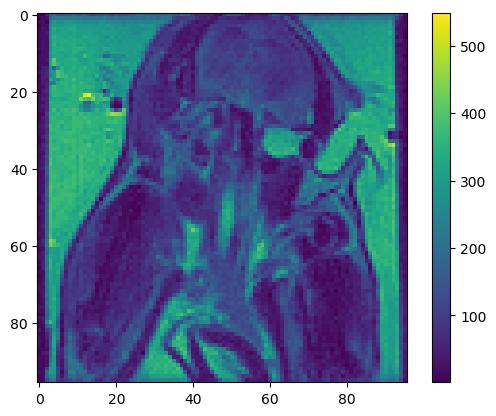

PyObject <matplotlib.colorbar.Colorbar object at 0x140a94208>

In [19]:
imshow(circshift(abs.(Ireco[:,:,10,1,1]),(0,5)))
colorbar()

Bruker does provide reconstruction data as well:

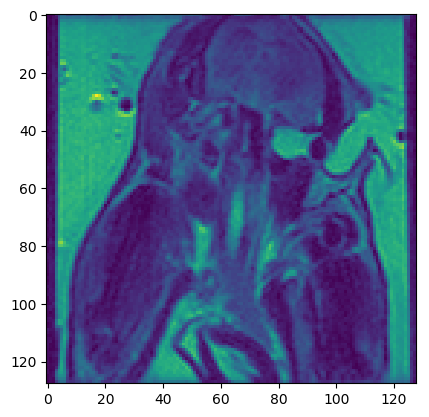

PyObject <matplotlib.image.AxesImage object at 0x11f1d1a90>

In [20]:
b = BrukerFile("brukerfileCart")
Ibruker = recoData(b)

imshow(Ibruker[:,:,10]')

## Conversion

As we have loaded a `RawAcquistionData` from file, it is also possible to save it.
Currently, it is only possible to save into the ISMRMRD data format, which seems
to be the most sensible choice anyway.

In [21]:
fout = ISMRMRDFile("outputfile.h5")

save(fout, raw);

We may load the data to check that it is still the same:

In [22]:
rawCopy = RawAcquisitionData(fout)

rawCopy.params

Dict{String,Any} with 18 entries:
  "institutionName"         => "Luebeck"
  "sequence_type"           => "T2_RARE"
  "echo_spacing"            => 17.0
  "stationName"             => "ICON 1T"
  "studyID"                 => "mk190404a"
  "seriesDescription"       => "T2_RARE (E2)"
  "TR"                      => 3221.44
  "TE"                      => 85.0
  "measurementID"           => "2"
  "H1resonanceFrequency_Hz" => 178492384
  "patientName"             => "mouse head ex vivo"
  "receiverChannels"        => 1
  "trajectory"              => "cartesian"
  "referringPhysicianName"  => "nmrsu"
  "flipAngle_deg"           => 90.0
  "encodedFOV"              => [0.027, 0.027, 0.0125]
  "systemVendor"            => "Bruker"
  "encodedSize"             => [96, 96, 1]

# Trajectory

Let us access the sampling trajectory

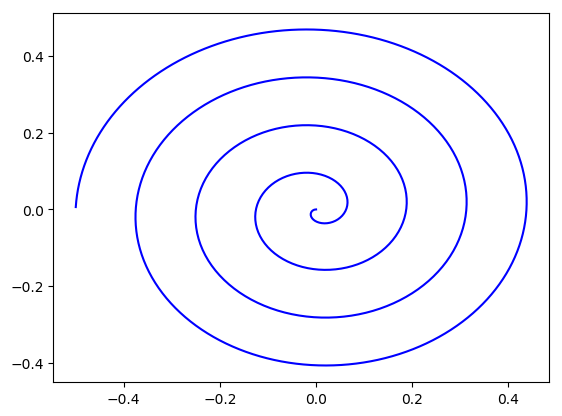

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x11f2138d0>

In [23]:
f = ISMRMRDFile("simple_spiral.h5");

acq = acquisitionData(RawAcquisitionData(f))
t = trajectory(acq)
nodes = kspaceNodes(t)

figure(2)
plot(nodes[1,1:909],nodes[2,1:909],"b")

# Develop MRIReco.jl

Changing MRIReco.jl is pretty easy. Go into the package manager and develop the package

In [24]:
] dev MRIReco

┌ Info: Path `/Users/knopp/.julia/dev/MRIReco` exists and looks like the correct package, using existing path
└ @ Pkg.Types /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Pkg/src/Types.jl:645


 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


Now the code is located in

   `/Users/knopp/.julia/dev/MRIReco` 
   
and can be directly modified. 

Note that Julia requires a restart, if you change code. This limitation
can be circumvented by using the `Revise.jl` package (loo at the Github page)